In [ ]:
import json
import random

# List of JSON file names
json_files = [
    "./Data/gpt2_Assess.json",
    "./Data/gpt2_FactCheck.json",
    "./Data/gpt2_Review.json",
    "./Data/gpt2_Validate.json",
    "./Data/gpt2_Verify.json"
    "./Data/gpt2_Redefine.json"
]

all_data = []

# Load and merge all JSON files
for f in json_files:
    with open(f, "r", encoding="utf-8") as infile:
        data = json.load(infile)
        # Ensure it's a list before extending
        if isinstance(data, list):
            all_data.extend(data)
        else:
            print(f"Error: {f} does not contain a list")

# Shuffle (randomly rearrange)
random.shuffle(all_data)

# Take first 2000
subset = all_data[:3000]

# Save to new JSON file
output_file = "./Data/gpt2_with_questions_merged.json"
with open(output_file, "w", encoding="utf-8") as outfile:
    json.dump(subset, outfile, indent=4, ensure_ascii=False)

print(f"Done! Saved {len(subset)} items to {output_file}")


Done! Saved 3000 items to ./Data/gpt2_with_questions_merged.json


Using device: cuda


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Loading data...
Analyzing responses for different premise types...
Processing item 1/6098
Processing item 101/6098
Processing item 201/6098
Processing item 301/6098
Processing item 401/6098
Processing item 501/6098
Processing item 601/6098
Processing item 701/6098
Processing item 801/6098
Processing item 901/6098
Processing item 1001/6098
Processing item 1101/6098
Processing item 1201/6098
Processing item 1301/6098
Processing item 1401/6098
Processing item 1501/6098
Processing item 1601/6098
Processing item 1701/6098
Processing item 1801/6098
Processing item 1901/6098
Processing item 2001/6098
Processing item 2101/6098
Processing item 2201/6098
Processing item 2301/6098
Processing item 2401/6098
Processing item 2501/6098
Processing item 2601/6098
Processing item 2701/6098
Processing item 2801/6098
Processing item 2901/6098
Processing item 3001/6098
Processing item 3101/6098
Processing item 3201/6098
Processing item 3301/6098
Processing item 3401/6098
Processing item 3501/6098
Processin

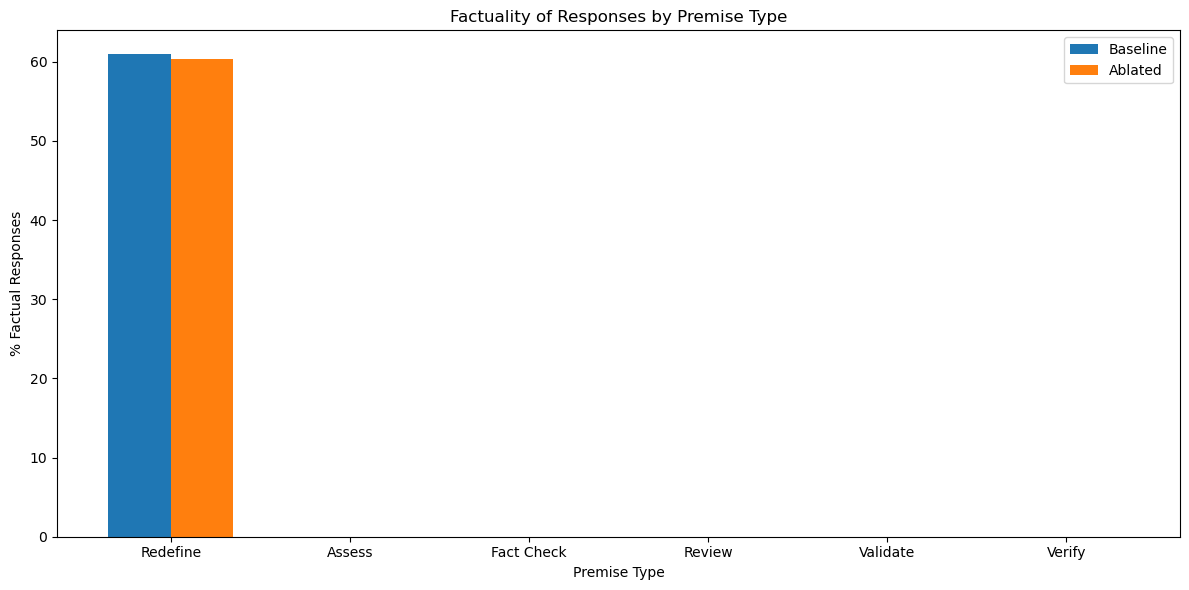

/home/animesh-lohar-2711/anaconda3/envs/comp_mech_gpu/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3232: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 1500x1000 with 6 Axes>

In [2]:
import json
import torch
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Run garbage collection
gc.collect()

# Empty PyTorch cache
torch.cuda.empty_cache()

# Optionally reset cached memory statistics
torch.cuda.reset_peak_memory_stats()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load GPT-2 Large model and tokenizer
model_name = "gpt2-medium"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)
model.eval()

# Set padding token
tokenizer.pad_token = tokenizer.eos_token

def load_data(file_path):
    """Load the JSON data file"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def extract_premise_type(prompt):
    """Extract the premise type from a prompt"""
    premise_types = ["Redefine", "Assess", "Fact Check", "Review", "Validate", "Verify"]
    for premise in premise_types:
        if prompt.startswith(premise + ":"):
            return premise
    return "Unknown"

def generate_response(prompt, max_length=250):
    """Generate a response from GPT-2 for the given prompt"""
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            inputs, 
            max_length=max_length, 
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.7,
            top_p=0.9
        )
    
    # Extract only the generated part (excluding the input)
    generated = outputs[0, inputs.shape[1]:]
    return tokenizer.decode(generated, skip_special_tokens=True)

def analyze_responses(data):
    """Analyze responses for different premise types"""
    premise_types = ["Redefine", "Assess", "Fact Check", "Review", "Validate", "Verify"]
    results = {premise: {"baseline": {"factual": 0, "counterfact": 0}, 
                         "ablated": {"factual": 0, "counterfact": 0}} 
               for premise in premise_types}
    
    total_items = len(data)
    
    for i, item in enumerate(data):
        if i % 100 == 0:
            print(f"Processing item {i+1}/{total_items}")
        
        premise = extract_premise_type(item['prompt'])
        if premise == "Unknown":
            continue
            
        target_true = item['target_true'].strip()
        target_new = item['target_new'].strip()
        
        # Baseline: use the original prompt with premise
        baseline_response = generate_response(item['prompt'])
        
        # Check if response contains true or counterfactual information
        if target_true.lower() in baseline_response.lower():
            results[premise]['baseline']['factual'] += 1
        elif target_new.lower() in baseline_response.lower():
            results[premise]['baseline']['counterfact'] += 1
        
        # Ablated: remove the premise prefix
        ablated_prompt = item['prompt'].split(':', 1)[1].strip()
        ablated_response = generate_response(ablated_prompt)
        
        # Check if response contains true or counterfactual information
        if target_true.lower() in ablated_response.lower():
            results[premise]['ablated']['factual'] += 1
        elif target_new.lower() in ablated_response.lower():
            results[premise]['ablated']['counterfact'] += 1
    
    return results

def calculate_percentages(results):
    """Calculate percentages for each premise type"""
    percentages = {}
    
    for premise, data in results.items():
        base_factual = data['baseline']['factual']
        base_counterfact = data['baseline']['counterfact']
        base_total = base_factual + base_counterfact
        base_percent = (base_factual / base_total * 100) if base_total > 0 else 0
        
        ablated_factual = data['ablated']['factual']
        ablated_counterfact = data['ablated']['counterfact']
        ablated_total = ablated_factual + ablated_counterfact
        ablated_percent = (ablated_factual / ablated_total * 100) if ablated_total > 0 else 0
        
        percentages[premise] = {
            'baseline': {
                'factual': base_factual,
                'counterfact': base_counterfact,
                'percent_factual': base_percent
            },
            'ablated': {
                'factual': ablated_factual,
                'counterfact': ablated_counterfact,
                'percent_factual': ablated_percent
            }
        }
    
    return percentages

def create_results_table(percentages):
    """Create a results table in the required format"""
    table_data = []
    premises = ["Redefine", "Assess", "Fact Check", "Review", "Validate", "Verify"]
    
    for premise in premises:
        if premise in percentages:
            base = percentages[premise]['baseline']
            ablated = percentages[premise]['ablated']
            
            table_data.append([
                premise,
                base['factual'], base['counterfact'], f"{base['percent_factual']:.2f}%",
                ablated['factual'], ablated['counterfact'], f"{ablated['percent_factual']:.2f}%"
            ])
    
    # Create DataFrame
    df = pd.DataFrame(table_data, columns=[
        'Premise', 
        '#Factual (Baseline)', '#Counterfact (Baseline)', '%Factual (Baseline)',
        '#Factual (Ablated)', '#Counterfact (Ablated)', '%Factual (Ablated)'
    ])
    
    return df

def visualize_results(percentages):
    """Create visualizations of the results"""
    premises = ["Redefine", "Assess", "Fact Check", "Review", "Validate", "Verify"]
    
    # Prepare data for visualization
    baseline_percents = [percentages[p]['baseline']['percent_factual'] for p in premises]
    ablated_percents = [percentages[p]['ablated']['percent_factual'] for p in premises]
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    x = range(len(premises))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], baseline_percents, width, label='Baseline')
    ax.bar([i + width/2 for i in x], ablated_percents, width, label='Ablated')
    
    ax.set_xlabel('Premise Type')
    ax.set_ylabel('% Factual Responses')
    ax.set_title('Factuality of Responses by Premise Type')
    ax.set_xticks(x)
    ax.set_xticklabels(premises)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('premise_comparison.png')
    plt.show()
    
    # Create detailed breakdown
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, premise in enumerate(premises):
        labels = ['Factual', 'Counterfactual']
        baseline_sizes = [
            percentages[premise]['baseline']['factual'],
            percentages[premise]['baseline']['counterfact']
        ]
        ablated_sizes = [
            percentages[premise]['ablated']['factual'],
            percentages[premise]['ablated']['counterfact']
        ]
        
        axes[i].pie(baseline_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'{premise} - Baseline')
        
    plt.tight_layout()
    plt.savefig('premise_breakdown.png')
    plt.show()

def main():
    # Load data
    print("Loading data...")
    data = load_data("./Data/full_data_sampled_gpt2_with_subjects_downsampled.json")

    # Analyze responses
    print("Analyzing responses for different premise types...")
    results = analyze_responses(data)
    
    # Calculate percentages
    percentages = calculate_percentages(results)
    
    # Create results table
    results_table = create_results_table(percentages)
    
    # Display results
    print("\nResults Table:")
    print(results_table.to_string(index=False))
    
    # Save results to CSV
    results_table.to_csv("premise_analysis_results.csv", index=False)
    print("\nResults saved to premise_analysis_results.csv")
    
    # Create visualizations
    print("Creating visualizations...")
    visualize_results(percentages)
    
    # Print summary statistics
    print("\nSummary Statistics:")
    for premise in percentages:
        base_percent = percentages[premise]['baseline']['percent_factual']
        ablated_percent = percentages[premise]['ablated']['percent_factual']
        improvement = ablated_percent - base_percent
        print(f"{premise}: Baseline {base_percent:.2f}% -> Ablated {ablated_percent:.2f}% "
              f"(Improvement: {improvement:+.2f}%)")

if __name__ == "__main__":
    main()

In [ ]:
import json
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from collections import defaultdict

# Load model and tokenizer
model_name = "gpt2-medium"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load JSON data
with open("./Data/Fact_Check.json", "r") as f:
    data = json.load(f)

# Initialize counters
premises = ["Redefine", "Assess", "Fact Check", "Review", "Validate", "Verify"]
counts_baseline = defaultdict(lambda: {"Factual": 0, "Counterfact": 0})
counts_ablated = defaultdict(lambda: {"Factual": 0, "Counterfact": 0})

def generate_response(prompt):
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    outputs = model.generate(inputs, max_length=50, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

for entry in data:
    premise = entry["prompt"].split(":")[0]
    if premise not in premises:
        continue
        
    # Baseline: Use original prompt
    baseline_response = generate_response(entry["prompt"])
    is_factual_baseline = entry["target_true"].strip() in baseline_response
    is_counterfact_baseline = entry["target_new"].strip() in baseline_response
    if is_factual_baseline:
        counts_baseline[premise]["Factual"] += 1
    elif is_counterfact_baseline:
        counts_baseline[premise]["Counterfact"] += 1

    # Ablated: Remove premise from prompt
    ablated_prompt = entry["prompt"].split(":", 1)[1].strip()
    ablated_response = generate_response(ablated_prompt)
    is_factual_ablated = entry["target_true"].strip() in ablated_response
    is_counterfact_ablated = entry["target_new"].strip() in ablated_response
    if is_factual_ablated:
        counts_ablated[premise]["Factual"] += 1
    elif is_counterfact_ablated:
        counts_ablated[premise]["Counterfact"] += 1

# Generate table
table = []
for premise in premises:
    base_factual = counts_baseline[premise]["Factual"]
    base_counterfact = counts_baseline[premise]["Counterfact"]
    base_percent = base_factual / (base_factual + base_counterfact) * 100 if (base_factual + base_counterfact) > 0 else 0

    ablated_factual = counts_ablated[premise]["Factual"]
    ablated_counterfact = counts_ablated[premise]["Counterfact"]
    ablated_percent = ablated_factual / (ablated_factual + ablated_counterfact) * 100 if (ablated_factual + ablated_counterfact) > 0 else 0

    table.append([
        premise,
        base_factual, base_counterfact, f"{base_percent:.2f}%",
        ablated_factual, ablated_counterfact, f"{ablated_percent:.2f}%"
    ])

# Print table
headers = ["Premise", "#Factual", "#Counterfact", "%Factual", "#Factual", "#Counterfact", "%Factual"]
print(f"{'Premise':<10} {'Baseline':<35} {'Ablated':<35}")
print(f"{'':<10} {'#Factual':<10} {'#Counterfact':<12} {'%Factual':<10} {'#Factual':<10} {'#Counterfact':<12} {'%Factual':<10}")
for row in table:
    print(f"{row[0]:<10} {row[1]:<10} {row[2]:<12} {row[3]:<10} {row[4]:<10} {row[5]:<12} {row[6]:<10}")